# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4','pionminus5']
filename2 = 'newDB'#'electron1'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

In [3]:
if False:
    data1 = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    data1.loc[data1['phi0'] > -99, 'phi0'] = 0
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        idata.loc[idata['phi0'] > -99, 'phi0'] = 0
        data1 = pd.concat([data1,idata], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)

    data = pd.concat([data1,data2], sort=False)
    data = data.sample(frac = 1)
    data['phi0'] = data['phi0'].astype('int32')
    data['centrality'] = data['centrality'].astype('int32')
    data['zvertex'] = data['zvertex'].astype('float16')
    data['pt'] = data['pt'].astype('float16')
    data['e/p'] = data['e/p'].astype('float16')
    data['n0'] = data['n0'].astype('int32')
    data['disp'] = data['disp'].astype('float16')
    data['chi2'] = data['chi2'].astype('float16')
    data['npe0'] = data['npe0'].astype('int32')
    data['prob'] = data['prob'].astype('float16')
    data.head()
    
    data['disp2'] = data.apply(lambda row: row['disp']**2, axis=1)
    data['n0*disp'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp']), axis=1)
    data['n0*disp2'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp'])**0.5, axis=1)
    data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
    data['e/p*prob'] = data.apply(lambda row:  math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2*(row['prob']), axis=1)
    data['n0*prob'] = data.apply(lambda row: (row['n0']-2)*(row['prob']+0.001), axis=1)
    data['prob-1'] = data.apply(lambda row: 1./(1.00001-row['prob'])**0.5, axis=1)
    data['e/p*pt'] = data.apply(lambda row: ((row['pt'])**0.5)*math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['n0*pt'] = data.apply(lambda row: (row['n0']-2)*(row['pt']+0.001)**0.5, axis=1)
    #data['e/p*centrality'] = data.apply(lambda row: row['e/p']*(row['centrality']+0.001)**0.5, axis=1)
    #data['n0*centrality'] = data.apply(lambda row: row['n0']*(row['centrality']+0.001)**0.5, axis=1)
    data['n0-2'] = data.apply(lambda row: (row['n0']-2)*(row['n0']), axis=1)
    data['e/p-0.8'] = data.apply(lambda row: math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['pt-1'] = data.apply(lambda row: row['pt']**-1, axis=1)
    data['pt2'] = data.apply(lambda row: row['pt']**2, axis=1)
    data['centrality-2'] = data.apply(lambda row: row['centrality']**-2, axis=1)
    data.head()

In [3]:
data = pd.read_csv(filepath+f'{filename2}.csv')
#data2.loc[data2['phi0'] > -99, 'phi0'] = 1
#data2 = data2[:100000]

In [4]:
print(data.size, data.shape)

341659176 (14235799, 24)


In [5]:
# удалим лишние колонки
data = data.drop(columns = ['zvertex'])

In [7]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


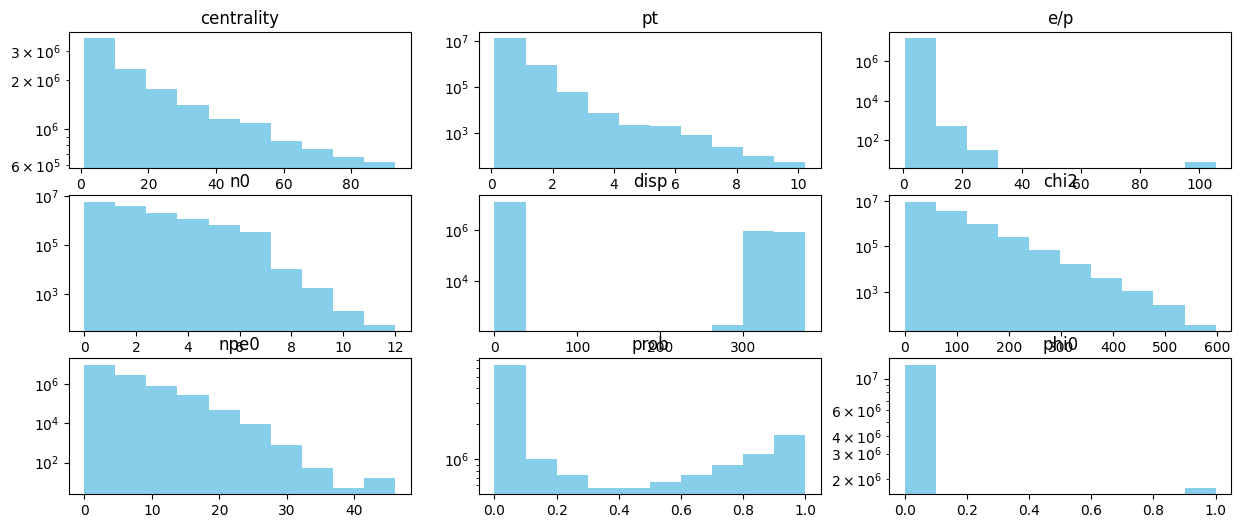

In [8]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [9]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [10]:
X_train_all, X_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

4745266 9490533


In [11]:
X_test

,centrality,pt,e/p,n0,disp,chi2,npe0,prob,disp2,n0*disp,...,e/p*prob,n0*prob,prob-1,e/p*pt,n0*pt,n0-2,e/p-0.8,pt-1,pt2,centrality-2
9490533,29,0.3477,0.9720,2,6.387,49.600,1,0.020360,40.790176,0.000000,...,0.000603,0.000000,1.010331,0.017478,0.000000,0.0,0.029642,2.876404,0.120865,0.001189
9490534,45,0.4900,0.7000,1,4.870,9.210,1,0.925300,23.727554,-0.170326,...,-0.009217,-0.926293,3.658392,-0.006973,-0.700707,-1.0,-0.009961,2.040857,0.240090,0.000494
9490535,6,0.5596,1.5530,0,336.500,42.530,0,0.000054,113232.250000,-0.005926,...,0.000030,-0.002108,1.000022,0.423849,-1.497425,-0.0,0.566609,1.787086,0.313119,0.027778
9490536,31,0.5425,0.6353,3,2.805,17.340,4,0.816000,7.866272,0.262834,...,-0.022145,0.816918,2.330679,-0.019990,0.737211,3.0,-0.027141,1.843384,0.294285,0.001041
9490537,14,0.4873,0.7120,1,6.010,14.770,2,0.560500,36.140762,-0.142618,...,-0.004349,-0.561547,1.508477,-0.005416,-0.698788,-1.0,-0.007759,2.052104,0.237466,0.005102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14235794,52,0.5060,1.1630,1,9.130,100.750,2,0.000076,83.408264,-0.098689,...,0.000010,-0.001076,1.000033,0.093763,-0.711941,-1.0,0.131831,1.976834,0.255894,0.000370
14235795,57,0.5405,0.6500,0,343.800,13.840,0,0.000428,118164.062500,-0.005801,...,-0.000010,-0.002855,1.000209,-0.016564,-1.471771,-0.0,-0.022529,1.850045,0.292170,0.000308
14235796,47,0.5127,0.8594,1,8.100,0.617,2,0.013176,65.635315,-0.109871,...,0.000046,-0.014176,1.006649,0.002524,-0.716725,-1.0,0.003525,1.950476,0.262856,0.000453
14235797,31,0.5757,0.9940,1,8.664,27.470,1,0.007748,75.065979,-0.103476,...,0.000292,-0.008748,1.003891,0.028597,-0.759397,-1.0,0.037691,1.737065,0.331412,0.001041


In [12]:
X_train, X_val = X_train_all[:cut_off_val], X_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [7]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

NameError: name 'X_train' is not defined

In [6]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [0.01, 0.2],
    "max_depth":[3,8],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[10]
    }


clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=4)

clf.fit(X_train, y_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

NameError: name 'GradientBoostingClassifier' is not defined

# Cross Validation

In [15]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97   4169886
           1       0.85      0.67      0.75    575380

    accuracy                           0.95   4745266
   macro avg       0.90      0.83      0.86   4745266
weighted avg       0.94      0.95      0.94   4745266



In [16]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

In [16]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC AUC Curve')

NameError: name 'y_test' is not defined

In [18]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.36941503874780507


In [36]:
i = 56000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.632 0.0204
0.5466389516517993 0.012880687865327733 0.6324985227154228


In [20]:
print(sum(predicted),len(predicted))

449550 4745266


In [8]:
kek_data = data
kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

NameError: name 'clf' is not defined

In [37]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: AIcute+=1
        else: AIcuth+=1
    if phi0: norm_e+=1
    else: norm_h+=1
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [38]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

10684 83748 0.523 0.013 0.645 0.012 0.019 0.02


In [39]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

1.348 1.234 0.915 1594


In [25]:
import pickle
with open('output/bdt.pkl','wb') as f:
    pickle.dump(clf,f)

print(clf.predict(kek_data[0:10]))

[0 0 0 0 0 0 0 0 0 1]


In [9]:
import pickle
# load
with open('output/bdt.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(kek_data[0:10]))

[0 0 0 0 0 0 0 0 0 1]


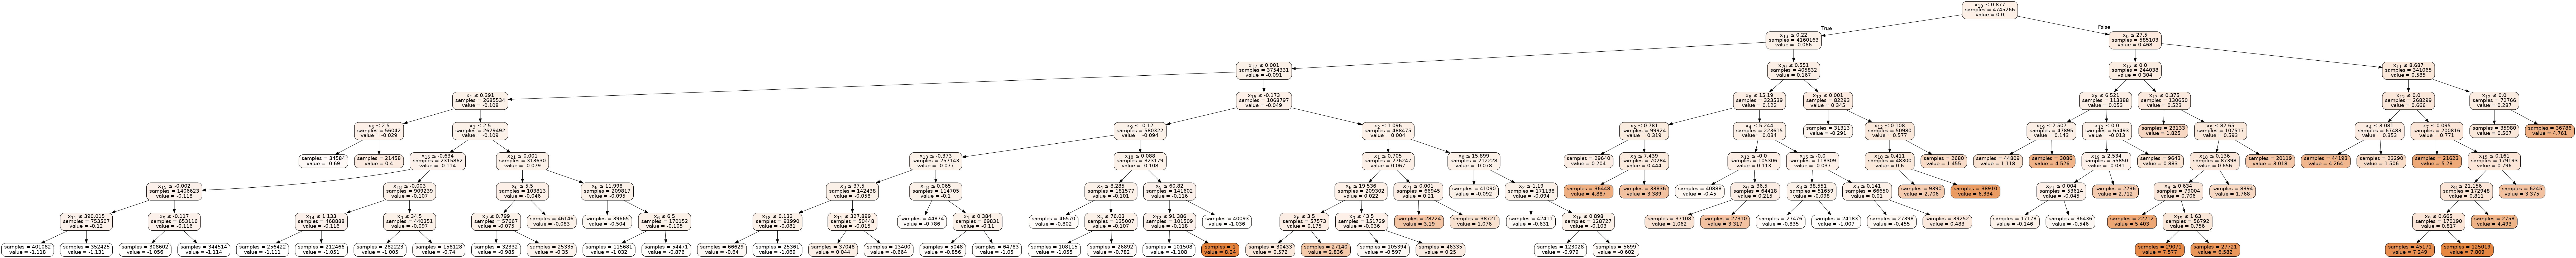

In [10]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [11]:
clf2.predict(kek_data[0:100])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:

clf2.predict_proba(kek_data[0:100])


array([[0.9683746 , 0.0316254 ],
       [0.92496724, 0.07503276],
       [0.97810883, 0.02189117],
       [0.94855605, 0.05144395],
       [0.77814121, 0.22185879],
       [0.98037647, 0.01962353],
       [0.98010401, 0.01989599],
       [0.93973346, 0.06026654],
       [0.97661522, 0.02338478],
       [0.38728875, 0.61271125],
       [0.94962134, 0.05037866],
       [0.97132303, 0.02867697],
       [0.3833047 , 0.6166953 ],
       [0.90674389, 0.09325611],
       [0.14468779, 0.85531221],
       [0.98100291, 0.01899709],
       [0.96166086, 0.03833914],
       [0.98016369, 0.01983631],
       [0.92961787, 0.07038213],
       [0.87602844, 0.12397156],
       [0.98147775, 0.01852225],
       [0.96334214, 0.03665786],
       [0.97577019, 0.02422981],
       [0.96981658, 0.03018342],
       [0.29501934, 0.70498066],
       [0.97020402, 0.02979598],
       [0.96920712, 0.03079288],
       [0.97497633, 0.02502367],
       [0.97098943, 0.02901057],
       [0.65731475, 0.34268525],
       [0.

In [13]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 0.01, 'n_estimators': 10}


In [104]:
clf2.best_estimator_.predict_proba(kek_data[9:20])

array([[0.38728875, 0.61271125],
       [0.94962134, 0.05037866],
       [0.97132303, 0.02867697],
       [0.3833047 , 0.6166953 ],
       [0.90674389, 0.09325611],
       [0.14468779, 0.85531221],
       [0.98100291, 0.01899709],
       [0.96166086, 0.03833914],
       [0.98016369, 0.01983631],
       [0.92961787, 0.07038213],
       [0.87602844, 0.12397156]])

In [106]:
y = clf2.best_estimator_[0, 0].predict(kek_data[9:19].values.tolist())

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(1,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(kek_data[9:19].values.tolist())
#print(y)
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[0.99423075 0.18105809 0.10576209 0.99810023 0.30001841 0.99992921
 0.05369119 0.13378172 0.05597561 0.2398442 ]


In [28]:
best_gbc = clf2.best_estimator_

In [79]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(kek_data[9:19]))
arr = clf2.decision_function(kek_data[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(kek_data[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[ 0.45872325 -2.93649557 -3.52256468  0.47554481 -2.2745105   1.77688831
 -3.94428965 -3.22219045 -3.90020563 -2.58083414]
[0.61271125 0.05037866 0.02867697 0.6166953  0.09325611 0.85531221
 0.01899709 0.03833914 0.01983631 0.07038213]
0.2


In [93]:
y = []
for i in range(10):
    y0=[]
    for j in range(10):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(kek_data[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

[[3.3888391306829506, 2.878135342986096, 1.4193777847979723, 0.6570770645458388, 1.270621179842815, 1.1445453397646381, 0.16008904177794708, 0.7968301671611647, -0.10072850072650237, 0.5769930283083015], [-0.6904154486343066, -0.23504658935649922, -0.4363519484582169, -0.8015967235083988, -0.41816715059046256, -0.43284430568225923, -0.7800801237706563, -0.017483158432960933, -0.00907539434960902, -0.9632536834551109], [-0.7398096676154524, -1.0299513926595563, -1.0120821745533675, -0.9436894863119857, -0.818751383704793, -0.7763563416209548, -0.7929432250854574, -0.9453382078970527, -0.3383678005239939, -0.31737043101706375], [4.761179091645439, 1.9618403076720288, 0.6405684247066866, 0.6570770645458388, 1.270621179842815, 1.1445453397646381, 0.16008904177794708, 0.8924201469420047, 0.7631522116302437, 0.024394568693704714], [-0.6904154486343066, -0.647332025364674, -0.6367082182441729, -0.31967429700777406, -0.9389240167748973, 0.711346055628888, 0.4905712147107499, 0.1119586524138160

In [81]:
arr = [clf2.best_estimator_[i, 0].predict(kek_data[9:19].values.tolist()) for i in range(10)]
print(sum(arr),1./(1.+np.exp(-sum(arr)/5.)))

[12.19177958 -4.78431453 -7.71466011 12.27588738 -1.47438919 18.78260484
 -9.82328495 -6.21278894 -9.60286483 -3.0060074 ] [0.91970576 0.27750673 0.17610945 0.92093925 0.42681011 0.97716857
 0.12296394 0.22399108 0.12779769 0.35406886]


In [116]:
best_gbc.estimators_[0,0].predict(kek_data[9:19].values.tolist())

array([ 3.38883913, -0.69041545, -0.73980967,  4.76117909, -0.69041545,
        7.2489262 , -1.13082869, -0.78171199, -1.13082869, -0.69041545])

In [112]:
X = np.array([
    [3.3888391306829506, 2.878135342986096, 1.4193777847979723, 0.6570770645458388, 1.270621179842815, 1.1445453397646381, 0.16008904177794708, 0.7968301671611647, -0.10072850072650237, 0.5769930283083015],
    [-0.6904154486343066, -0.23504658935649922, -0.4363519484582169, -0.8015967235083988, -0.41816715059046256, -0.43284430568225923, -0.7800801237706563, -0.017483158432960933, -0.00907539434960902, -0.9632536834551109],
    [-0.7398096676154524, -1.0299513926595563, -1.0120821745533675, -0.9436894863119857, -0.818751383704793, -0.7763563416209548, -0.7929432250854574, -0.9453382078970527, -0.3383678005239939, -0.31737043101706375],
    [4.761179091645439, 1.9618403076720288, 0.6405684247066866, 0.6570770645458388, 1.270621179842815, 1.1445453397646381, 0.16008904177794708, 0.8924201469420047, 0.7631522116302437, 0.024394568693704714],
    [-0.6904154486343066, -0.647332025364674, -0.6367082182441729, -0.31967429700777406, -0.9389240167748973, 0.711346055628888, 0.4905712147107499, 0.11195865241381608, 0.13831744927600345, 0.30647144741716514],
    [7.248926204731297, 2.548029503045927, 1.7012628159152718, 1.505706201931383, 1.390623222258111, 1.1201473702403488, 1.2509360753260246, 0.7701424368692487, 0.6753532694551171, 0.5714777361144433],
    [-1.130828689783816, -1.0710334907149897, -1.050961890433842, -1.0297147350800981, -1.015472440480887, -1.0089519900084236, -0.7579283626912593, -0.916912991404101, -0.8782266737129215, -0.9632536834551109],
    [-0.7817119860948762, -0.7396013672781966, -0.7616489003709678, -0.028652086784960923, -0.9261702444407237, -0.6787656971486086, -0.3450485538610513, -0.49581536133440407, -0.6297647535090437, -0.8256099871585197],
    [-1.130828689783816, -1.0710334907149897, -1.0120821745533675, -1.0499863049675608, -1.0173976238744258, -0.7763563416209548, -0.7929432250854574, -0.9111750595209389, -0.8778082335215323, -0.9632536834551109],
    [-0.6904154486343066, -0.647332025364674, -0.4363519484582169, 0.4102126904241127, -1.0173976238744258, -0.3306882655129574, 0.4905712147107499, -0.017483158432960933, 0.13831744927600345, -0.9054402883151867]
])

# Define your output vector Y
Y = np.array([ 0.45872325, -2.93649557, -3.52256468, 0.47554481, -2.2745105,  1.77688831, -3.94428965, -3.22219045, -3.90020563 ,-2.58083414])

# Solve for A using least squares
A, residuals, rank, s = np.linalg.lstsq(X, Y, rcond=None)

# Output the coefficients
print("Coefficients (a0 to a9):", A)

Coefficients (a0 to a9): [-0.35209262 -2.1182146   1.10566442  0.32338589  4.10652726  0.25465914
  1.26461274  0.14956599 -0.60488291  0.12947141]


In [95]:
print(sum(X[0]))

12.191779579141222


In [33]:
z = y/10.

In [34]:
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))

In [35]:
i=10
print(proba_loc[i],z[i])

IndexError: index 10 is out of bounds for axis 0 with size 10

In [109]:
print(export_text(sub_tree_42, feature_names=list(X_train.columns)))

NameError: name 'X_train' is not defined

In [110]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " && "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " y = "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [111]:
rules = get_rules(sub_tree_42, list(X_train.columns), None)
print(f"double mytree{list(X_train.columns)}")
print('{')
for r in rules:
    print("    ",r)
print ('return y;')
print('};')

NameError: name 'X_train' is not defined

In [97]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print "def tree({}):".format(", ".join(feature_names))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print "{}if {} <= {}:".format(indent, name, threshold)
            recurse(tree_.children_left[node], depth + 1)
            print "{}else:  # if {} > {}".format(indent, name, threshold)
            recurse(tree_.children_right[node], depth + 1)
        else:
            print "{}return {}".format(indent, tree_.value[node])

    recurse(0, 1)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (521263583.py, line 7)

In [15]:
def create_model(C):
    clf = LogisticRegression(solver='newton-cholesky', max_iter=10000, C=C, verbose=1)
    return clf

Возьмем логистическую регрессию, в качестве солвера берем newton-cholesky, так как в документации sklearn сказано, что он лучше работает с one-hot-encoded фичами.

In [16]:
def cv(data_train: pd.DataFrame, data_val, y_train, y_val):
    best_score = 0.5
    best_C = 0.1
    for C in [0.0001,0.001,0.01,0.05,0.1,1,10,100,1000,10000]:
        clf = create_model(C)
        clf.fit(data_train, y_train)
        y_pred_probs = clf.predict_proba(data_val)
        score = roc_auc_score(y_val, y_pred_probs[:, 1])
        if score > best_score:
            best_score = score
            best_C = C
            print("localy best C:", best_C)       
    print("the best C:", best_C)        
    best_model = create_model(best_C)
    return best_model

In [17]:
print(transformed_val.shape,y_val.shape)

NameError: name 'transformed_val' is not defined

In [18]:
clf = cv(transformed_train, transformed_val, y_train, y_val)

Newton iter=1
  Check Convergence
    1. max |gradient| 1623.4941991730032 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 584.9652169019487 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 246.24381777823515 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 142.45672855971196 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 80.28221064944248 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 24.02466304081971 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 3.137470735497903 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 0.0728428747464155 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 4.148187593364911e-05 <= 0.0001
    2. Newton decrement 4.3881509820581824e-10 <= 0.0001
  Solver did converge at loss = 0.18452967434842996.
localy best C: 0.0001
Newton iter=1
  Check Convergence
    1. max |gradient| 1621.398849365463 <= 0.0001
Newton iter=2
  Chec

Обучаем лучшую модель заново на тренировочном и валидационном датасете.

In [19]:
clf.fit(transformed_train_all, y_train_all)

Newton iter=1
  Check Convergence
    1. max |gradient| 1614.2817689419855 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 571.8142137277309 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 223.4800220184778 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 103.33179059546329 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 54.59005408894938 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 20.722553512304565 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 3.2909468553844197 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 0.11393116164729328 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 0.0004476116104154366 <= 0.0001
Newton iter=10
  Check Convergence
    1. max |gradient| 3.727139536937279e-08 <= 0.0001
    2. Newton decrement 3.0298548487298765e-11 <= 0.0001
  Solver did converge at loss = 0.17108381701905534.


LogisticRegression(C=0.05, max_iter=10000, solver='newton-cholesky', verbose=1)

In [20]:
y_pred_probs = clf.predict_proba(transformed_test)
y_pred = clf.predict(transformed_test)

In [21]:
clf

LogisticRegression(C=0.05, max_iter=10000, solver='newton-cholesky', verbose=1)

Посчитаем скоры (ROC AUC, log loss и f1 score).

log loss: 0.16875449389653988
roc auc: 0.948561911295735
f1 score: 0.6573268773981363


Text(0.5, 1.0, 'ROC AUC Curve')

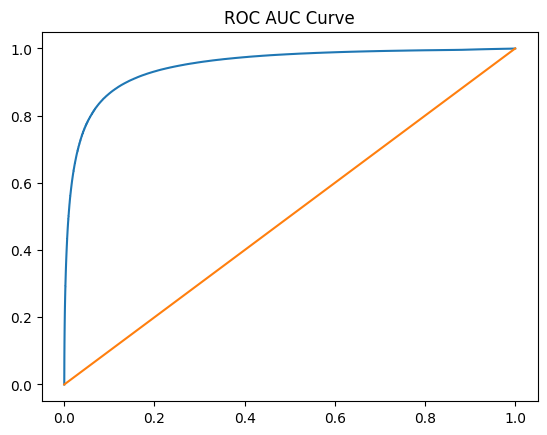

In [22]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC AUC Curve')

Сравним со скорами из бейзлайна. Бейзлайн: предсказываем все нулями

In [23]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.36941503874780507


Видим, что наша модель обгоняет бейзлайн по метрикам ROC AUC и Log Loss.

In [24]:
i = 36000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.57 0.0247
0.5980331947300741 0.014067051233534921 0.569755639751121


In [25]:
print(clf.intercept_)
for keff in clf.coef_[0]:
    print(keff)
output_data = [clf.intercept_,clf.coef_[0]]
with open("output/keffs.txt", "w") as txt_file:
    for line in output_data:
        txt_file.write("".join(str(line)) + "\n")

[-6.53545671]
0.021353069628557673
3.095279485270983
4.6382682200866014
-1.8282220434020535
-0.3175938636551022
-0.005021594683382745
0.2137918331373416
2.549257410200321
0.0008447746909219362
-7.047608340577657
9.517728631140908
7.72718467238114e-06
-4.149802548708278
0.043061809621984096
-0.005526510133862617
-4.888545044572229
0.048892128987606254
-0.17396866101759953
0.19471665020363357
0.44385071211159094
-0.6073048793423969
-0.4145894647254969


In [26]:
def answer(centrality,pt,ep,n0,disp,chi2,npe0,prob):
    ans = clf.coef_[0][0]*centrality+clf.coef_[0][1]*pt+clf.coef_[0][2]*ep+clf.coef_[0][3]*n0+\
        clf.coef_[0][4]*disp+clf.coef_[0][5]*chi2+clf.coef_[0][6]*npe0+clf.coef_[0][7]*prob+clf.intercept_[0]
    return ans

In [27]:
kek_data = data
kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.01789709787853305


In [28]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: AIcute+=1
        else: AIcuth+=1
    if phi0: norm_e+=1
    else: norm_h+=1
    if counter<10: 
        print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

[0.9821029 0.0178971] -4.584383858989346
[0.94405054 0.05594946] -1.1689460601287998
[0.99292798 0.00707202] -5.401172199730233
[0.94435972 0.05564028] -1.6382875392803573
[0.62569398 0.37430602] -7.765042163484157
[0.99826812 0.00173188] -6.872375927083802
[0.99734664 0.00265336] -4.1600957217368935
[0.88734095 0.11265905] -4.938941484253226
[0.9948106 0.0051894] -1.2789849730967333
[0.39055378 0.60944622] -2.351107580190833


In [29]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

10684 83748 0.523 0.013 0.583 0.013 0.023 0.025


In [30]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

1.119 1.115 0.996 1324
